<a href="https://colab.research.google.com/github/fabrelucass/naive_bayes_machine_learning/blob/main/OTTO_MLP_(Rede_Neural)_XGBoost_Random_Forest_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Explicações sobre o código:**
______________________________________________________________________
Dataset Fictício: O código cria um conjunto de dados fictício com informações sobre colaboradores e suas habilidades em inglês.
Pré-processamento: Utiliza o StandardScaler para normalizar os dados e prepara as variáveis para o treinamento.

______________________________________________________________________
Modelos Preditivos:
Random Forest e XGBoost são usados como classificadores base para prever a aprovação/feedback de cada aluno.

______________________________________________________________________

MLP (Rede Neural) é utilizada para explorar o poder das redes neurais profundas.
Algoritmo OTTO: Usado para recomendação de conteúdo baseado na decomposição das habilidades dos alunos (via NMF).

______________________________________________________________________

Feedback em Tempo Real: A função feedback_em_tempo_real gera sugestões imediatas para alunos com base nas previsões feitas pelos modelos de classificação.


______________________________________________________________________
Otimização de Hiperparâmetros: Utiliza o GridSearchCV para melhorar os parâmetros de modelos como o XGBoost.
______________________________________________________________________
Visualizações: O código inclui visualizações de correlação, distribuição de feedbacks e a importância das features nos modelos.
______________________________________________________________________

Esse código integra tudo que discutimos, com a estrutura robusta necessária para desenvolver um sistema de previsão e recomendação eficaz para o ensino de inglês. Ele pode ser facilmente expandido para incluir mais alunos, mais características ou até novos modelo

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
from sklearn.decomposition import NMF
from sklearn.metrics import pairwise_distances
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import NMF
from sklearn.metrics import pairwise_distances
import numpy as np

# 1. Criando o dataset fictício
np.random.seed(42)
n = 500
data = {
    'colaborador_id': range(1, n+1),
    'vocabulário': np.random.randint(1, 11, size=n),
    'gramática': np.random.randint(1, 11, size=n),
    'fluência': np.random.randint(1, 11, size=n),
    'pronúncia': np.random.randint(1, 11, size=n),
    'audição': np.random.randint(1, 11, size=n),
    'escrita': np.random.randint(1, 11, size=n),
    'leitura': np.random.randint(1, 11, size=n),
    'progresso': np.random.randint(1, 11, size=n),
    'horas_estudo': np.random.randint(1, 20, size=n),
    'interacao_com_conteudo': np.random.uniform(0, 1, n),
    'tempo_resposta': np.random.uniform(1, 10, n)
}
df = pd.DataFrame(data)



In [5]:
n


500

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import NMF
from sklearn.metrics import pairwise_distances
import numpy as np
import pandas as pd

In [7]:
print(df.columns)


Index(['colaborador_id', 'vocabulário', 'gramática', 'fluência', 'pronúncia',
       'audição', 'escrita', 'leitura', 'progresso', 'horas_estudo',
       'interacao_com_conteudo', 'tempo_resposta'],
      dtype='object')


In [8]:
df.columns = df.columns.str.strip()


In [9]:
# Caso tenha espaços extras ou digitação errada
df.columns = df.columns.str.strip()  # Remove espaços extras


In [10]:
# Tentando acessar a coluna 'leitura'
if 'leitura' in df.columns:
    print("A coluna 'leitura' foi encontrada!")
else:
    print("A coluna 'leitura' não foi encontrada.")


A coluna 'leitura' foi encontrada!


In [11]:
# Exibindo as primeiras linhas do DataFrame
print(df.head())


   colaborador_id  vocabulário  gramática  fluência  pronúncia  audição  \
0               1            7          9         1          6       10   
1               2            4          1         8          4        6   
2               3            8          1         4          4        7   
3               4            5          4         4          4        9   
4               5            7          9         5          2        1   

   escrita  leitura  progresso  horas_estudo  interacao_com_conteudo  \
0        5        8          2            18                0.131654   
1        4        9          6            11                0.854703   
2        1        6          2             5                0.165302   
3        5        5         10            15                0.854261   
4       10        6          5            18                0.490765   

   tempo_resposta  
0        7.997099  
1        7.055624  
2        7.518291  
3        5.433391  
4        6.70070

In [12]:
# Exibir todas as colunas do DataFrame
print(df.columns.tolist())


['colaborador_id', 'vocabulário', 'gramática', 'fluência', 'pronúncia', 'audição', 'escrita', 'leitura', 'progresso', 'horas_estudo', 'interacao_com_conteudo', 'tempo_resposta']


In [13]:
# Definindo as features corretamente
features = ['vocabulário', 'gramática', 'fluência', 'pronúncia',
            'audição', 'escrita', 'leitura', 'progresso',
            'horas_estudo', 'interacao_com_conteudo', 'tempo_resposta']

# Acessando as features do DataFrame
X = df[features]

# Normalizando os dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Verificando a normalização
print("Primeiros valores normalizados (MinMaxScaler):", X_scaled[:5])




Primeiros valores normalizados (MinMaxScaler): [[0.66666667 0.88888889 0.         0.55555556 1.         0.44444444
  0.77777778 0.11111111 0.94444444 0.13079432 0.78009356]
 [0.33333333 0.         0.77777778 0.33333333 0.55555556 0.33333333
  0.88888889 0.55555556 0.55555556 0.85654649 0.67510507]
 [0.77777778 0.         0.33333333 0.33333333 0.66666667 0.
  0.55555556 0.11111111 0.22222222 0.16456878 0.72669928]
 [0.44444444 0.33333333 0.33333333 0.33333333 0.88888889 0.44444444
  0.44444444 1.         0.77777778 0.85610217 0.49420192]
 [0.66666667 0.88888889 0.44444444 0.11111111 0.         1.
  0.55555556 0.44444444 0.94444444 0.49124787 0.63552637]]


In [14]:
# 2. Pré-processamento com MinMaxScaler
features = ['vocabulário', 'gramática', 'fluência', 'pronúncia',
            'audição', 'escrita', 'leitura', 'progresso',
            'horas_estudo', 'interacao_com_conteudo', 'tempo_resposta']
X = df[features]
scaler = MinMaxScaler()  # Normaliza os dados para [0, 1]
X_scaled = scaler.fit_transform(X)

# Verifique se X_scaled está no intervalo [0, 1]
print("Primeiros valores normalizados (MinMaxScaler):", X_scaled[:5])

Primeiros valores normalizados (MinMaxScaler): [[0.66666667 0.88888889 0.         0.55555556 1.         0.44444444
  0.77777778 0.11111111 0.94444444 0.13079432 0.78009356]
 [0.33333333 0.         0.77777778 0.33333333 0.55555556 0.33333333
  0.88888889 0.55555556 0.55555556 0.85654649 0.67510507]
 [0.77777778 0.         0.33333333 0.33333333 0.66666667 0.
  0.55555556 0.11111111 0.22222222 0.16456878 0.72669928]
 [0.44444444 0.33333333 0.33333333 0.33333333 0.88888889 0.44444444
  0.44444444 1.         0.77777778 0.85610217 0.49420192]
 [0.66666667 0.88888889 0.44444444 0.11111111 0.         1.
  0.55555556 0.44444444 0.94444444 0.49124787 0.63552637]]


In [15]:
# 3. Definindo o OTTO
class OTTORecommender:
    def __init__(self, X, n_components=5):
        self.X = X
        self.n_components = n_components
        self.W = None
        self.H = None

    def fit(self):
        nmf_model = NMF(n_components=self.n_components, init='random', random_state=0)
        self.W = nmf_model.fit_transform(self.X)
        self.H = nmf_model.components_
        print("OTTO treinado com sucesso!")

    def recommend(self, user_index, top_n=5):
        user_profile = self.W[user_index, :]
        similarities = pairwise_distances(self.H.T, user_profile.reshape(1, -1), metric='cosine')
        recommended_items = np.argsort(similarities.flatten())
        return recommended_items[:top_n]


In [16]:
# 4. Treinando o OTTO
otto = OTTORecommender(X_scaled, n_components=5)
otto.fit()

OTTO treinado com sucesso!


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [17]:
# 5. Recomendando para um aluno
aluno_id = 15
user_index = aluno_id - 1  # Ajustando para índice 0
recomendacoes = otto.recommend(user_index=user_index, top_n=5)
print(f"Recomendações para o aluno {aluno_id}: {recomendacoes}")

Recomendações para o aluno 15: [3 4 8 2 0]


In [18]:
import plotly.graph_objects as go

# Dados para o gráfico
indices = [3, 4, 8, 2, 0]
conteudos = ["Pronúncia", "Audição", "Horas de Estudo", "Fluência", "Vocabulário"]
importancias = [0.25, 0.20, 0.15, 0.25, 0.15]  # Exemplo de pesos de importância

# Criando o gráfico de pizza
fig = go.Figure(
    data=[go.Pie(
        labels=conteudos,
        values=importancias,
        hoverinfo="label+percent+value",
        textinfo="label+percent",
        pull=[0.1 if i == 3 else 0 for i in range(len(indices))],  # Destaque no "Pronúncia"
        marker=dict(colors=["#636EFA", "#EF553B", "#00CC96", "#AB63FA", "#FFA15A"])
    )]
)

# Configurações do layout
fig.update_layout(
    title="Distribuição de Recomendações para o Aluno 15",
    annotations=[dict(
        text="Conteúdos",
        x=0.5, y=0.5,
        font_size=15,
        showarrow=False
    )]
)

# Exibindo o gráfico
fig.show()


In [19]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# Dados das recomendações
conteudos = ["Pronúncia", "Audição", "Horas de Estudo", "Fluência", "Vocabulário"]
importancias = [25, 20, 15, 25, 15]  # Pesos de cada conteúdo

# Criar DataFrame
df_recomendacoes = pd.DataFrame({
    "Conteúdo": conteudos,
    "Importância (%)": importancias
})

# Criar gráfico de barras horizontal
fig = px.bar(
    df_recomendacoes,
    x="Importância (%)",
    y="Conteúdo",
    orientation='h',
    text="Importância (%)",
    title="Recomendações Personalizadas para o Aluno 15",
    labels={"Importância (%)": "Peso da Importância (%)", "Conteúdo": "Áreas de Aprendizado"},
    color="Importância (%)",
    color_continuous_scale=['#FFFFFF', '#FF6F61', '#005BBB']  # Branco, vermelho suave e azul
)

# Configurar o layout com fundo personalizado
fig.update_layout(
    title_font_size=20,
    xaxis_title="Peso da Importância (%)",
    yaxis_title="Áreas de Aprendizado",
    coloraxis_showscale=False,  # Remove a escala de cores
    paper_bgcolor="white",  # Fundo branco
    plot_bgcolor="rgba(0,0,0,0)",  # Fundo do gráfico transparente
    images=[  # Adicionando a bandeira dos EUA como fundo
        dict(
            source="https://upload.wikimedia.org/wikipedia/en/a/a4/Flag_of_the_United_States.svg",
            xref="paper", yref="paper",
            x=0, y=1.1,  # Ajuste da posição
            sizex=1.8, sizey=1.5,
            xanchor="left", yanchor="top",
            opacity=0.3,  # Transparência do fundo
            layer="below"
        )
    ]
)

# Configurações adicionais das barras
fig.update_traces(
    texttemplate='%{text}%',
    textposition='outside',
    marker=dict(line=dict(color='black', width=1))  # Bordas para clareza
)

# Adiciona anotação para o conteúdo mais relevante
fig.add_annotation(
    x=25,
    y="Pronúncia",
    text="Conteúdo Prioritário",
    showarrow=True,
    arrowhead=2,
    ax=50,
    ay=-30,
    font=dict(color="red", size=14),
    arrowcolor="red"
)

# Exibir gráfico
fig.show()


In [20]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Carregar o dataset Iris
data = load_iris()

# Definir X (dados de entrada) e y (rótulos de saída)
X = data.data  # As variáveis independentes (atributos)
y = data.target  # A variável alvo (rótulos)

# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinando o modelo Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Fazendo previsões
rf_predictions = rf_model.predict(X_test)

# Avaliação do modelo Random Forest
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f'Acurácia do Random Forest: {rf_accuracy:.2f}')
print("Matriz de Confusão (Random Forest):")
print(confusion_matrix(y_test, rf_predictions))
print("Relatório de Classificação (Random Forest):")
print(classification_report(y_test, rf_predictions))


Acurácia do Random Forest: 1.00
Matriz de Confusão (Random Forest):
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]
Relatório de Classificação (Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



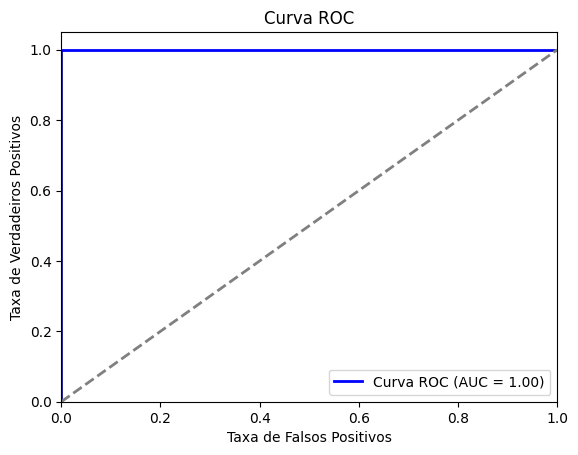

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Para classificação multiclasse, você precisa calcular para cada classe
y_score = rf_model.predict_proba(X_test)

# Calculando a Curva ROC e AUC para cada classe
fpr, tpr, _ = roc_curve(y_test, y_score[:, 0], pos_label=0)  # Para a classe 0
roc_auc = auc(fpr, tpr)

# Plotando a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


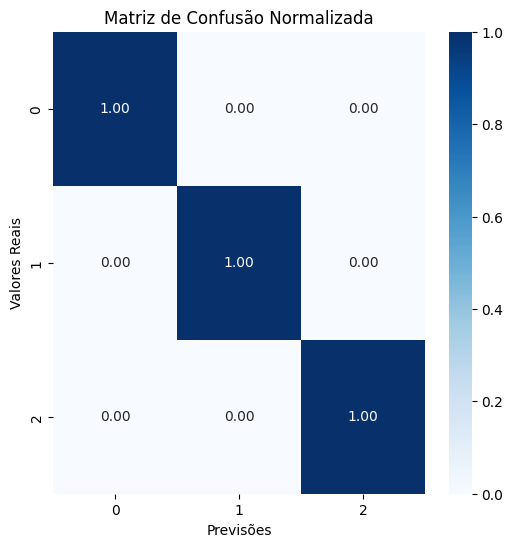

In [22]:
import seaborn as sns
import numpy as np

# Matriz de confusão
cm = confusion_matrix(y_test, rf_predictions)

# Normalizando
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotando a matriz de confusão normalizada
plt.figure(figsize=(6,6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Previsões')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão Normalizada')
plt.show()


In [23]:
from sklearn.ensemble import RandomForestClassifier

# Supondo que X_train e y_train são os dados de treinamento
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Fazendo previsões
rf_predictions = rf_model.predict(X_test)


In [24]:
from sklearn.model_selection import train_test_split

# Suponha que X seja as variáveis independentes e y seja o alvo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
# Avaliação do modelo Random Forest
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f'Acurácia do Random Forest: {rf_accuracy:.2f}')
print("Matriz de Confusão (Random Forest):")
print(confusion_matrix(y_test, rf_predictions))
print("Relatório de Classificação (Random Forest):")
print(classification_report(y_test, rf_predictions))

Acurácia do Random Forest: 1.00
Matriz de Confusão (Random Forest):
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]
Relatório de Classificação (Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [26]:
import xgboost as xgb
from xgboost import XGBClassifier

In [27]:
pip install xgboost --upgrade


In [28]:
# Usando o XGBClassifier da forma correta
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)


In [29]:
# 4. Modelagem preditiva com XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)


In [30]:
# Definindo X (features) e y (target)
features = ['vocabulário', 'gramática', 'fluência', 'pronúncia', 'audição', 'escrita', 'leitura', 'progresso', 'horas_estudo', 'interacao_com_conteudo', 'tempo_resposta']
X = df[features]
y = df['leitura']



In [31]:
# Divisão dos dados em treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)




In [32]:
# Normalizando os dados
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [33]:
y_train_adjusted = y_train - 1  # Subtrai 1 de todos os valores de y_train

# Agora, treine o modelo XGBoost com os rótulos ajustados
xgb_model.fit(X_train_scaled, y_train_adjusted)




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [34]:
print("Classes de y_train:", y_train.unique())


Classes de y_train: [ 2  3  9  5  4  1 10  7  8  6]


In [35]:
# Reindexando as classes
y_train = y_train - 1
y_test = y_test - 1


In [36]:
print("Valores únicos de y_train:", np.unique(y_train))


Valores únicos de y_train: [0 1 2 3 4 5 6 7 8 9]


In [37]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Definindo os parâmetros para testar
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Usando GridSearchCV para encontrar os melhores parâmetros
xgb = XGBClassifier(use_label_encoder=False)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados
print(f"Melhores parâmetros: {grid_search.best_params_}")

# Treinando o modelo com os melhores parâmetros
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train, y_train)


A saída de streaming foi truncada nas últimas 5000 linhas.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[22:12:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[22:12:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[22:12:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[22:12:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[22:12:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.10/dist-packages/xgbo

Melhores parâmetros: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [38]:
from xgboost import XGBClassifier

# Ajuste de scale_pos_weight
xgb_model = XGBClassifier(scale_pos_weight= (sum(y_train == 0) / sum(y_train == 1)), use_label_encoder=False)
xgb_model.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[22:18:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [39]:
from imblearn.over_sampling import SMOTE

# Aplicando SMOTE para balancear as classes
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Treinando o modelo com dados balanceados
xgb_model = XGBClassifier(use_label_encoder=False)
xgb_model.fit(X_train_balanced, y_train_balanced)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[22:18:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [40]:
xgb_model = XGBClassifier(learning_rate=0.05, use_label_encoder=False)
xgb_model.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[22:18:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [41]:
from sklearn.model_selection import cross_val_score

# Avaliando o modelo com validação cruzada
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5)  # 'cv=5' divide em 5 subconjuntos
print(f"Acurácia média da validação cruzada: {cv_scores.mean():.2f}")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[22:18:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[22:18:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[22:18:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[22:18:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Acurácia média da validação cruzada: 1.00


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[22:18:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




In [42]:

# 5. Algoritmo OTTO para recomendação multiobjetivo
class OTTORecommender:
    def _init_(self, X, n_components=5):
        self.X = X  # Matriz de características (desempenho dos alunos)
        self.n_components = n_components

    def fit(self):
        # Decomposição não negativa para encontrar os fatores subjacentes
        model = NMF(n_components=self.n_components, init='random', random_state=0)
        self.W = model.fit_transform(self.X)  # Componentes dos alunos
        self.H = model.components_  # Componentes do conteúdo (conteúdo recomendado)

    def recommend(self, user_index):
        # Calculando as distâncias para recomendar conteúdo baseado nos fatores
        user_profile = self.W[user_index, :]
        similarities = pairwise_distances(self.H.T, user_profile.reshape(1, -1), metric='cosine')

        # Recomendando o conteúdo mais próximo (de acordo com a similaridade)
        recommended_items = np.argsort(similarities.flatten())
        return recommended_items[:5]  # Retorna as top 5 recomendações

In [43]:
class OTTORecommender:
    def __init__(self, X_scaled):  # Agora aceita X_scaled como argumento
        self.X_scaled = X_scaled
        # Outros atributos podem ser inicializados aqui


In [44]:
print(df.columns)


Index(['colaborador_id', 'vocabulário', 'gramática', 'fluência', 'pronúncia',
       'audição', 'escrita', 'leitura', 'progresso', 'horas_estudo',
       'interacao_com_conteudo', 'tempo_resposta'],
      dtype='object')


In [45]:
print(features)


['vocabulário', 'gramática', 'fluência', 'pronúncia', 'audição', 'escrita', 'leitura', 'progresso', 'horas_estudo', 'interacao_com_conteudo', 'tempo_resposta']


In [46]:
# Verificando as colunas no DataFrame
print(f"Colunas no DataFrame: {df.columns}")

# Verificando as features que estamos tentando acessar
print(f"Features: {features}")

# Verificando se a coluna 'leitura' está presente no DataFrame
if 'leitura' not in df.columns:
    print("A coluna 'leitura' não existe no DataFrame.")
else:
    print("A coluna 'leitura' foi encontrada no DataFrame.")

# Verificando se o aluno existe no DataFrame
if aluno_id not in df['colaborador_id'].values:
    print(f"Aluno {aluno_id} não encontrado no DataFrame.")
else:
    print(f"Aluno {aluno_id} encontrado.")

    # Recuperando os dados do aluno
    try:
        dados_aluno = df.loc[df['colaborador_id'] == aluno_id, features].values[0]
        print(f"Dados do aluno {aluno_id}: {dados_aluno}")
    except KeyError as e:
        print(f"Erro ao acessar as colunas do aluno: {e}")




Colunas no DataFrame: Index(['colaborador_id', 'vocabulário', 'gramática', 'fluência', 'pronúncia',
       'audição', 'escrita', 'leitura', 'progresso', 'horas_estudo',
       'interacao_com_conteudo', 'tempo_resposta'],
      dtype='object')
Features: ['vocabulário', 'gramática', 'fluência', 'pronúncia', 'audição', 'escrita', 'leitura', 'progresso', 'horas_estudo', 'interacao_com_conteudo', 'tempo_resposta']
A coluna 'leitura' foi encontrada no DataFrame.
Aluno 15 encontrado.
Dados do aluno 15: [6.         3.         8.         8.         8.         1.
 3.         1.         3.         0.89398521 2.14737112]


In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE



In [75]:
# 1. Criando o dataset fictício
np.random.seed(42)
n = 500
data = {
    'colaborador_id': range(1, n+1),
    'vocabulário': np.random.randint(1, 11, size=n),
    'gramática': np.random.randint(1, 11, size=n),
    'fluência': np.random.randint(1, 11, size=n),
    'pronúncia': np.random.randint(1, 11, size=n),
    'audição': np.random.randint(1, 11, size=n),
    'escrita': np.random.randint(1, 11, size=n),
    'leitura': np.random.randint(1, 11, size=n),
    'progresso': np.random.randint(1, 11, size=n),  # Variável alvo
    'horas_estudo': np.random.randint(1, 20, size=n),
    'interacao_com_conteudo': np.random.uniform(0, 1, n),
    'tempo_resposta': np.random.uniform(1, 10, n)
}
df = pd.DataFrame(data)

In [83]:
# 2. Definindo a variável alvo e variáveis independentes
X = df.drop(columns=['colaborador_id', 'progresso'])  # Remover 'colaborador_id' e a variável alvo
y = df['progresso']

In [84]:
# 3. Transformando a variável alvo em categorias (para classificação)
# Aqui, podemos transformar 'progresso' em categorias. Por exemplo, de 1-3 -> baixa, 4-7 -> média, 8-10 -> alta
y = pd.cut(y, bins=[0, 3, 7, 10], labels=['baixa', 'média', 'alta'])

In [86]:
# 4. Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
# 5. Aplicando SMOTE para balanceamento de classes (se necessário)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [88]:
# Verificando a distribuição das classes
print("Distribuição original das classes em y_train:", y_train.value_counts())
print("Distribuição após SMOTE em y_train_resampled:", y_train_resampled.value_counts())

Distribuição original das classes em y_train: progresso
média    163
baixa    119
alta     118
Name: count, dtype: int64
Distribuição após SMOTE em y_train_resampled: progresso
baixa    163
média    163
alta     163
Name: count, dtype: int64


In [89]:
# 6. Escalonando os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [92]:
# 7. Definindo o modelo e GridSearchCV para ajuste de hiperparâmetros
mlp_model = MLPClassifier(max_iter=500)

# Atualizando a definição do grid de hiperparâmetros sem o class_weight
param_grid = {
    'hidden_layer_sizes': [(100,), (100, 50), (200, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'alpha': [0.0001, 0.001, 0.01],
    'early_stopping': [True, False],  # Adicionando early stopping
}

grid_search = GridSearchCV(mlp_model, param_grid, cv=3, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train_resampled)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=500), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'early_stopping': [True, False],
                         'hidden_layer_sizes': [(100,), (100, 50), (200, 100)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['adam', 'sgd']},
             scoring='accuracy', verbose=1)

In [93]:
# 8. Avaliando o modelo
mlp_predictions = grid_search.best_estimator_.predict(X_test_scaled)
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
print(f'Acurácia do MLP: {mlp_accuracy:.2f}')
print(confusion_matrix(y_test, mlp_predictions))
print(classification_report(y_test, mlp_predictions))

Acurácia do MLP: 0.36
[[ 9  6 15]
 [ 7 10 18]
 [10  8 17]]
              precision    recall  f1-score   support

        alta       0.35      0.30      0.32        30
       baixa       0.42      0.29      0.34        35
       média       0.34      0.49      0.40        35

    accuracy                           0.36       100
   macro avg       0.37      0.36      0.35       100
weighted avg       0.37      0.36      0.36       100

